**Explanation**

## Reputation-Based Multipartite Ranking

This notebook implements a multipartite ranking system using user clusters and reputation to improve item ranking fairness and robustness.

### **How it Works**

1.  **Cluster Rankings:**
    * Initial item rankings are computed within each user cluster, requiring minimum rating counts.
    * Clusters smaller than a given threshold are assigned to the Complementary cluster.
2.  **Intra-Cluster Reputation:**
    * Within each cluster reputations are calculated, weighted by cluster size.
3.  **Convergence & Visualization:**
    * The system iterates until rankings converge.
4.  **Weighted Average:**
    * A weighted average ranking for each item is computed, using the cluster sizes as weight.
5.  **Top 3 Clusters**
    * A visualization of the distribution of rankings on the top 3 clusters is provided.

### **This notebook will:**

* Cluster users,
* Compute cluster-specific rankings with thresholds,
* Calculate cluster reputations,
* Generate weighted average rankings using reputation,
* Visualize distribution of rankings.

**1.    Imports**

In [22]:
import pandas as pd
import numpy as np
import networkx as nx
import zlib
import matplotlib.pyplot as plt
from itertools import combinations
import sys
import math
from collections import Counter
from scipy.stats import zscore
from scipy.stats import kendalltau
from collections import defaultdict


compressed_sizes = {}


**2.    Load dataset**

In [23]:
# Define dataset path
file_path = "/home/martimsbaltazar/Desktop/tese/datasets/BookCrossing/Shortened_Ratings.csv"

df = pd.read_csv(file_path, sep=',')

# Rename columns
df.columns = ['user_id', 'item_id', 'normalized_rating']

# Normalize the rating
df['normalized_rating'] = df['normalized_rating'] / 10

# Display first few rows
df.head()

item_raters = defaultdict(set)

for item_id, user_id in zip(df['item_id'], df['user_id']):
    item_raters[item_id].add(user_id)

**3.    Dictionary with pre-computed values**

In [24]:
def compute_compressed_sizes(user_ratings):
    
    for user, ratings in user_ratings.items():
        u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings.items()))
        compressed_sizes[user] = len(zlib.compress(u_string.encode()))
    
    return compressed_sizes


**4.    Similarity distances**

In [25]:
def linear_similarity(u, v, user_ratings):
    common_items = set(user_ratings[u].keys()).intersection(set(user_ratings[v].keys()))
    if not common_items:
        return 0  # If no common items, similarity is 0

    diff_sum = sum(abs(user_ratings[u][i] - user_ratings[v][i]) for i in common_items)
    ls_value = 1 - (diff_sum / len(common_items))
    return max(0, ls_value)  # Ensure similarity is non-negative

# Compression Similarity with precomputed sizes
def compression_similarity(u, v, user_ratings):
    u_string = "".join(f"{k}:{v} " for k, v in sorted(user_ratings[u].items()))
    v_string = "".join(f"{k}:{v} " for k, v in sorted(user_ratings[v].items()))
    c_uv = len(zlib.compress((u_string + v_string).encode()))
    c_u = compressed_sizes[u]
    c_v = compressed_sizes[v]
    return 1 - (c_uv - min(c_u, c_v)) / max(c_u, c_v)

# Kolmogorov Similarity with precomputed sizes
def kolmogorov_similarity(u, v, user_ratings):
    #ordena a priori os ratings dado por cada user
    c_u = compressed_sizes[u]
    c_v = compressed_sizes[v]
    return 1 / (1 + abs(c_u - c_v))

def jaccard_similarity(u, v, user_ratings):
    items_u = set(user_ratings[u].keys())
    items_v = set(user_ratings[v].keys())
    
    intersection = items_u.intersection(items_v)
    union = items_u.union(items_v)
    
    if not union:
        return 0  # Avoid division by zero
    
    return len(intersection) / len(union)

def cosine_similarity(u, v, user_ratings):
    ratings_u = user_ratings[u]
    ratings_v = user_ratings[v]
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    
    if not common_items:
        return 0  # If no common items, similarity is 0

    # Compute dot product and magnitudes
    dot_product = sum(ratings_u[i] * ratings_v[i] for i in common_items)
    magnitude_u = math.sqrt(sum(ratings_u[i] ** 2 for i in ratings_u))
    magnitude_v = math.sqrt(sum(ratings_v[i] ** 2 for i in ratings_v))
    
    if magnitude_u == 0 or magnitude_v == 0:
        return 0  # Avoid division by zero
    
    return dot_product / (magnitude_u * magnitude_v)



**5.    Similarity Graph**

In [26]:
# Compute user similarity matrix and construct graph (with precomputed sizes)
def compute_similarity_matrix(user_ratings, similarity_measure, compressed_sizes, similarity_threshold):
    similarity_graph = nx.Graph()

    # Step 1: Add all users as nodes (ensures isolated users are included)
    similarity_graph.add_nodes_from(user_ratings.keys())

    # Step 2: Compute pairwise similarities and add edges if similarity > 0.99
    for (u, v) in combinations(user_ratings.keys(), 2):
        sim = similarity_measure(u,v,user_ratings)
        if sim > similarity_threshold:
            similarity_graph.add_edge(u, v, weight=sim)

    return similarity_graph

# Detect user clusters from similarity graph
def detect_groups(similarity_graph,min_cluster_size):
    """ Detect user clusters from similarity graph and assign small clusters to a complementary cluster. """
    clusters = list(nx.connected_components(similarity_graph))
    complementary_cluster = set()
    filtered_clusters = []

    for cluster in clusters:
        if len(cluster) < min_cluster_size:
            complementary_cluster.update(cluster)  # Add small clusters to the complementary cluster
        else:
            filtered_clusters.append(cluster)  # Keep large clusters as they are

    if complementary_cluster:
        filtered_clusters.append(complementary_cluster)  # Add complementary cluster if it has users

    filtered_cluster_sizes = [len(group) for group in filtered_clusters]
    print("Number of clusters: ", len(filtered_clusters))
    print("complementary_cluster: ", len(complementary_cluster))
    mean_size = np.mean(filtered_cluster_sizes)
    std_size = np.std(filtered_cluster_sizes)
    z_score = (len(complementary_cluster) - mean_size) / std_size if std_size > 0 else float('inf')
    print("z_score: ", z_score)

    return filtered_clusters

**6.    Reputation-based intra-clustering**

In [34]:
def compute_cluster_ratings(user_groups):
    """ Compute initial ratings per cluster based only on the items rated by at least 5 users in the cluster. """
    cluster_item_ratings = {}

    # Iterate through each user cluster
    for cluster_idx, user_set in enumerate(user_groups, start=1): 
        cluster_df = df[df["user_id"].isin(user_set)]  # Filter dataset to only include users in the cluster
        item_rating_counts = cluster_df["item_id"].value_counts()  # Count ratings per item
        
        # Filter items that have at least x ratings
        #TODO
        valid_items = item_rating_counts[item_rating_counts >= 1].index  

        # Compute the mean only for valid items
        filtered_avg_ratings = cluster_df[cluster_df["item_id"].isin(valid_items)].groupby("item_id")["normalized_rating"].mean().to_dict()

        cluster_item_ratings[cluster_idx] = filtered_avg_ratings

    return cluster_item_ratings


def compute_reputation_adjusted_ratings_optimized(cluster_item_ratings, user_groups, lambda_factor=0.95, tol=1e-2, max_iter=50):
    clusters = cluster_item_ratings.keys()
    prev_ratings = {c: cluster_item_ratings[c].copy() for c in clusters}
    user_reputations_by_cluster = {}

    for cluster in clusters:
        user_reputations_by_cluster[cluster] = {user: 1.0 for user in user_groups[cluster - 1]}  # Init reputations

    for _ in range(max_iter):
        converged = True
        new_ratings = {}

        for cluster in clusters:
            cluster_users = user_groups[cluster - 1]
            cluster_df = df[df["user_id"].isin(cluster_users)]
            user_grouped = dict(tuple(cluster_df.groupby("user_id")))
            item_grouped = dict(tuple(cluster_df.groupby("item_id")))
            item_ratings = prev_ratings[cluster]
            user_reputation = user_reputations_by_cluster[cluster]

            # Update reputations
            for user, user_df in user_grouped.items():
                ratings = user_df[["item_id", "normalized_rating"]].values
                errors = [
                    abs(rating - item_ratings[item])
                    for item, rating in ratings if item in item_ratings
                ]
                avg_error = np.mean(errors) if errors else 0
                user_reputation[user] = max(0, 1 - lambda_factor * avg_error)

            # Update item ratings
            new_item_ratings = {}
            for item, item_df in item_grouped.items():
                users = item_df["user_id"].values
                ratings = item_df["normalized_rating"].values
                weights = np.array([user_reputation.get(u, 0) for u in users])
                if weights.sum() > 0:
                    new_item_ratings[item] = min(1.0, np.dot(weights, ratings) / weights.sum())
                else:
                    new_item_ratings[item] = item_ratings.get(item, 0)

                # Check convergence
                if abs(new_item_ratings[item] - item_ratings.get(item, 0)) > tol:
                    converged = False

            new_ratings[cluster] = new_item_ratings
            user_reputations_by_cluster[cluster] = user_reputation

        prev_ratings = new_ratings

        if converged:
            break

    return prev_ratings, user_reputations_by_cluster

def compute_weighted_average_cluster_ratings(cluster_item_ratings, user_groups):
    """Compute weighted average ratings for each item across clusters using cluster size as weight."""
    item_weighted_sums = {}
    item_total_weights = {}
    
    # Iterate over clusters and their item ratings
    for cluster_idx, item_ratings in cluster_item_ratings.items():
        cluster_size = len(user_groups[cluster_idx - 1])  # Cluster index is 1-based, user_groups is 0-based
        
        for item, rating in item_ratings.items():
            if item not in item_weighted_sums:
                item_weighted_sums[item] = 0
                item_total_weights[item] = 0
            
            # Add weighted contribution
            item_weighted_sums[item] += rating * cluster_size
            item_total_weights[item] += cluster_size
    
    # Compute weighted averages and round to the nearest decimal place
    weighted_averages = {item: round(item_weighted_sums[item] / item_total_weights[item], 1) for item in item_weighted_sums}
    
    return weighted_averages


def round_ratings_to_one_decimal(new_ratings):
    """Round all item ratings to the nearest one decimal place."""
    return {cluster: {item: round(rating, 1) for item, rating in items.items()} for cluster, items in new_ratings.items()}




**7.    Plot Generation**

In [28]:
def plot_top_3_clusters(cluster_ratings):
    """Plot a bar chart showing the rating distribution for the three largest clusters with bins."""
    # Sort clusters by size (number of items rated) in descending order
    top_clusters = sorted(cluster_ratings.keys(), key=lambda c: len(cluster_ratings[c]), reverse=True)[:3]

    # Define bins from 0.1 to 1.0 (inclusive)
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    plt.figure(figsize=(12, 5))

    # Adjust vertical position offset for each cluster
    vertical_offset = 0.0

    for cluster in top_clusters:
        # Flatten ratings in the cluster
        ratings = list(cluster_ratings[cluster].values())

        # Digitize ratings into bins
        bin_indices = np.digitize(ratings, bins, right=True)
        bin_counts = Counter(bin_indices)

        # Create an aligned count array
        counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

        # Plot the bar chart for the cluster, adjusting the position of the bars
        plt.bar(bin_labels, counts, width=0.07, alpha=0.6, label=f'Cluster {cluster}', bottom=vertical_offset)

        # Add value labels with a vertical offset for readability
        for i, count in enumerate(counts):
            if count > 0:
                plt.text(bin_labels[i], count + vertical_offset + 0.5, str(count), ha='center', fontsize=10)

        # Update the vertical offset for the next cluster
        vertical_offset += max(counts) + 2  # Adjust the offset based on the max count in the current cluster

    plt.xlabel("Item Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("COmpression 0.5 | reputation threshold 0.95")
    plt.xticks(bin_labels)
    plt.legend()
    plt.show()



def plot_weighted_average_distribution(weighted_average_dict):
    """Plot a bar chart showing the distribution of weighted average ratings with bins from 0.1 to 1.0."""
    # Flatten weighted averages
    ratings = list(weighted_average_dict.values())

    # Define bins from 0.1 to 1.0
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    # Digitize ratings into bins
    bin_indices = np.digitize(ratings, bins, right=True)
    bin_counts = Counter(bin_indices)

    # Create an aligned count array
    counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

    # Plot the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(bin_labels, counts, width=0.07, color='blue', alpha=0.7)

    # Add value labels
    for i, count in enumerate(counts):
        if count > 0:
            plt.text(bin_labels[i], count + 0.5, str(count), ha='center', fontsize=10)

    plt.xlabel("Weighted Average Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("Distribution of Weighted Average Ratings (Binned)")
    plt.xticks(bin_labels)
    plt.show()

**8.    Data Preprocessing**

In [29]:
# Prepare user ratings
user_ratings = {user: dict(zip(group["item_id"], group["normalized_rating"])) for user, group in df.groupby("user_id")}

compressed_sizes = compute_compressed_sizes(user_ratings)
print("comprimido")

comprimido


**9. Clustering Process**

In [30]:
# Choose similarity measure: linear_similarity, compression_similarity, kolmogorov_similarity
similarity_graph = compute_similarity_matrix(user_ratings, kolmogorov_similarity, compressed_sizes,0.99)

# Get threshold for complementary cluster
num_users = df["user_id"].nunique()
complementary_cluster_threshold = num_users * 0.005

# Detect user clusters from similarity graph
user_groups = detect_groups(similarity_graph, complementary_cluster_threshold)

# Print the number of detected clusters
print(f"User groups: {(user_groups)}")

print("number of user_groups: ", len(user_groups))

#count total number of elements in usergroups
total = 0
for group in user_groups:
    total += len(group)
print("total number of elements in usergroups: ", total)

#biggest user group, average size of user groups
biggest = 0
for group in user_groups:
    if len(group) > biggest:
        biggest = len(group)
print("biggest user group: ", biggest)

average = total / len(user_groups)
print("average size of user groups: ", average)





Number of clusters:  50
complementary_cluster:  2875
z_score:  6.975181581778489
User groups: [{13312, 37891, 131588, 46595, 110599, 41486, 48155, 91164, 28191, 257059, 155172, 96294, 179239, 260648, 33834, 65579, 44, 249386, 28205, 129073, 203829, 240696, 190524, 238141, 21570, 112195, 62532, 64582, 174152, 193611, 160332, 250444, 27214, 46159, 258132, 231510, 242268, 245852, 114271, 179295, 96355, 79973, 258156, 184942, 223857, 102002, 163447, 175738, 24699, 28284, 222334, 130177, 121988, 61574, 179334, 152205, 174227, 25238, 47257, 244895, 76965, 84135, 6139, 40620, 41135, 51375, 53942, 122040, 183483, 88254, 193216, 190658, 100547, 247495, 139976, 143055, 174290, 190676, 238294, 124635, 249052, 252637, 237283, 108786, 229621, 174327, 161023, 101123, 24325, 103685, 64775, 30474, 145163, 49933, 213773, 148754, 202514, 75032, 234784, 190753, 142626, 80691, 217395, 234805, 16695, 169272, 62778, 76602, 124730, 217917, 238910, 254779, 1348, 144717, 103761, 94036, 243544, 249178, 174429, 

**10. Ranking computation**


cluster_item_ratings:  {1: {'0002257203': 0.8, '0006363062': 0.6, '0006473377': 0.0, '0006493556': 0.7, '0006543073': 0.0, '0006548180': 0.7, '0007106572': 0.0, '0007110928': 0.0, '0020139713': 0.8, '0023376627': 0.5, '0024045411': 0.5, '0027888355': 1.0, '003013157X': 0.5, '0030506611': 0.0, '0060008032': 0.5, '0060008776': 0.7, '0060086246': 0.0, '0060096675': 0.6, '0060173289': 0.5, '0060185775': 0.8, '0060198346': 0.0, '0060199652': 0.0, '0060280662': 0.0, '0060391626': 0.7, '0060392258': 0.0, '0060393297': 0.0, '0060911271': 0.0, '0060934417': 0.0, '0060950552': 1.0, '0060959037': 0.0, '0060973722': 0.0, '0060976241': 0.9, '0060976845': 0.8, '0061008028': 0.7, '006101351X': 0.0, '0061030015': 0.0, '0061030597': 0.8, '0061031445': 0.0, '0061042323': 0.5, '0061053775': 0.0, '0061054437': 0.5, '0061056073': 0.9, '0061081841': 0.0, '0061092533': 0.0, '0061099708': 0.7, '0062501097': 0.7, '0062501143': 0.7, '0062502182': 0.0, '0062507249': 0.0, '0064400026': 0.95, '0064408612': 1.0, '0

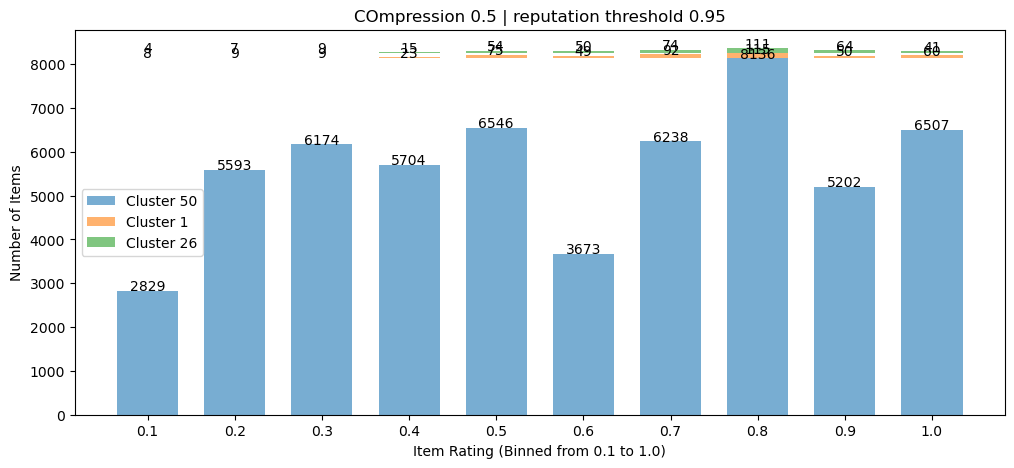

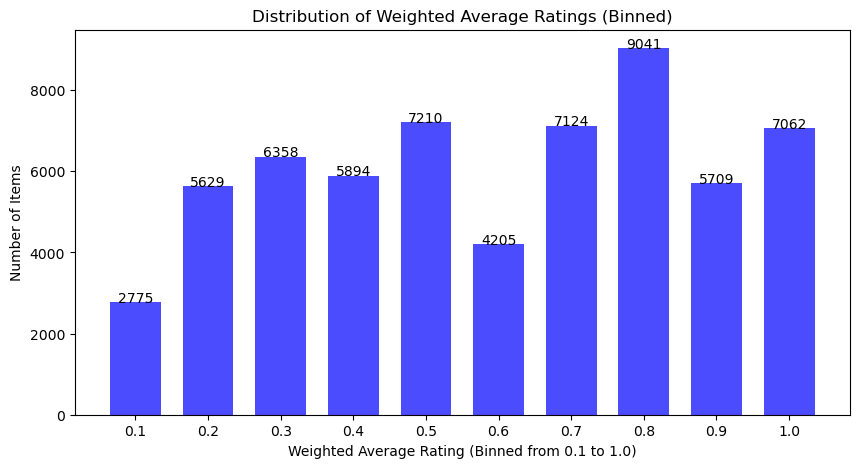

In [36]:
# Assuming user_groups is already defined
cluster_item_ratings = compute_cluster_ratings(user_groups)  # Step 1: Compute initial ratings

print("cluster_item_ratings: ", cluster_item_ratings)

cluster_item_ratings_reputation, reputations_by_cluster = compute_reputation_adjusted_ratings_optimized(cluster_item_ratings, user_groups)

print("cluster_item_ratings_reputation: ", cluster_item_ratings_reputation)

weighted_average_dict = compute_weighted_average_cluster_ratings(cluster_item_ratings_reputation, user_groups)

# round all clusters values 
rounded_ratings = round_ratings_to_one_decimal(cluster_item_ratings_reputation)

print("rounded_ratings: ", rounded_ratings)
print("len(rounded_ratings): ", len(rounded_ratings))

plot_top_3_clusters(rounded_ratings)  # Use actual dictionary
plot_weighted_average_distribution(weighted_average_dict)  # Use actual computed weighted averages




**11. Demographics**

In [38]:
file_path = "/home/martimsbaltazar/Desktop/tese/datasets/BookCrossing/Shortened_Users.csv"

# Load the file
demographics = pd.read_csv(file_path,sep=",")
print(demographics.columns)
# Strip column names to remove extra whitespace
demographics.columns = demographics.columns.str.strip()

# Convert Age to numeric, coercing non-numeric entries to NaN
demographics['Age'] = pd.to_numeric(demographics['Age'], errors='coerce')

# Drop rows where Age is NaN (non-integer or missing)
demographics = demographics.dropna(subset=['Age'])

# Convert to integer (now safe to do)
demographics['Age'] = demographics['Age'].astype(int)
demographics['User-ID'] = demographics['User-ID'].astype(int)

# Define age ranges
age_ranges = {
    "< 18": lambda age: age < 18,
    "18-24": lambda age: 18 <= age <= 24,
    "25-34": lambda age: 25 <= age <= 34,
    "35-44": lambda age: 35 <= age <= 44,
    "45-54": lambda age: 45 <= age <= 54,
    ">= 55": lambda age: age >= 55,
}

# Create age group buckets
age_groups = defaultdict(set)

# Populate groups
for _, row in demographics.iterrows():
    user_id = row['User-ID']
    age = row['Age']
    for label, condition in age_ranges.items():
        if condition(age):
            age_groups[label].add(user_id)
            break

# Print result summary
for group, users in age_groups.items():
    print(f"{group}: {len(users)} users")



Index(['User-ID', 'Age'], dtype='object')
45-54: 822 users
18-24: 792 users
35-44: 1428 users
< 18: 256 users
25-34: 2100 users
>= 55: 602 users


**12. Metrics**

**12.1 Effectiveness**

In [37]:
def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Compare only common items
    
    if len(common_items) < 2:
        return 0  # Need at least two items to compute Kendall's tau
    
    sorted_items = sorted(common_items)  # Ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

def compute_weighted_kendall_tau(cluster_item_ratings, user_groups):
    
    weighted_tau_sum = 0
    total_weight = sum(len(users) for users in user_groups)  # Total number of users as weight

    for cluster_id, item_ratings in cluster_item_ratings.items():
        tau_cluster = compute_kendall_tau(item_ratings, cluster_item_ratings_reputation[cluster_id])
        cluster_size = len(user_groups[cluster_id - 1])  # Cluster size as weight
        
        weighted_tau_sum += cluster_size * tau_cluster
    
    return weighted_tau_sum / total_weight if total_weight > 0 else 0

weighted_tau = compute_weighted_kendall_tau(cluster_item_ratings, user_groups)
print(f"Weighted Kendall’s τ: {weighted_tau:.4f}")


Weighted Kendall’s τ: 0.9971


**12.1 Bias**

In [40]:
def demographic_bias(demographic_group_users, cluster_reputations):
    """
    Compute demographic reputation gap per cluster and aggregate with weighted average.

    Args:
        demographic_group_users (set): Users in the selected demographic group.
        cluster_reputations (dict): {cluster_idx: {user_id: reputation}}

    Returns:
        cluster_gaps (dict): {cluster_idx: gap}
        weighted_avg_gap (float): Weighted average of gaps across clusters
    """
    cluster_gaps = {}
    cluster_weights = {}

    for cluster_idx, users_in_cluster in enumerate(user_groups, start=1):  # cluster indices start at 1
        reputations = cluster_reputations.get(cluster_idx, {})
        users_in_cluster = set(users_in_cluster)
        
        # Split target and complementary users within the cluster
        target_users = demographic_group_users & users_in_cluster
        complementary_users = users_in_cluster - target_users

        target_reps = [reputations[u] for u in target_users if u in reputations]
        comp_reps = [reputations[u] for u in complementary_users if u in reputations]

        # Compute gap only if both sides have data
        if target_reps and comp_reps:
            target_avg = sum(target_reps) / len(target_reps)
            comp_avg = sum(comp_reps) / len(comp_reps)
            gap = target_avg - comp_avg
        else:
            gap = 0.0  # Neutral if there's no sufficient data

        cluster_gaps[cluster_idx] = gap
        cluster_weights[cluster_idx] = len(users_in_cluster)

    # Compute weighted average gap across clusters
    total_weight = sum(cluster_weights.values())
    weighted_avg_gap = sum(
        cluster_gaps[c] * cluster_weights[c] for c in cluster_gaps
    ) / total_weight if total_weight > 0 else 0

    return cluster_gaps, weighted_avg_gap

# --------------------------------------------------
# AGE GROUP GAPS
print("\n=== Age-Based Reputation Gaps ===")
cluster_bias, weighted_bias = demographic_bias(age_groups["< 18"], reputations_by_cluster)
print(f"Reputation gap (< 18 vs rest): ", weighted_bias)
cluster_bias, weighted_bias = demographic_bias(age_groups["18-24"], reputations_by_cluster)
print(f"Reputation gap (18-24 vs rest): ", weighted_bias)
cluster_bias, weighted_bias = demographic_bias(age_groups["25-34"], reputations_by_cluster)
print(f"Reputation gap (25-34 vs rest): ", weighted_bias)
cluster_bias, weighted_bias = demographic_bias(age_groups["35-44"], reputations_by_cluster)
print(f"Reputation gap (35-44 vs rest): ", weighted_bias)
cluster_bias, weighted_bias = demographic_bias(age_groups["45-54"], reputations_by_cluster)
print(f"Reputation gap (45-54 vs rest): ", weighted_bias)
cluster_bias, weighted_bias = demographic_bias(age_groups[">= 55"], reputations_by_cluster)
print(f"Reputation gap (>= 55 vs rest): ", weighted_bias)


=== Age-Based Reputation Gaps ===
Reputation gap (< 18 vs rest):  0.008974555545360124
Reputation gap (18-24 vs rest):  2.921463379424279e-05
Reputation gap (25-34 vs rest):  -0.0006062447170475465
Reputation gap (35-44 vs rest):  0.001033625629140073
Reputation gap (45-54 vs rest):  0.0007599152099490369
Reputation gap (>= 55 vs rest):  -0.006419567385357293
